In [53]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [54]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


In [87]:
print(train_filenames[:1])

['/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg']


In [55]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [56]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
print('train size :',train_size)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

train size : 4185
4185
1047


### 정상 이미지와 폐렴 이미지 구분하기

In [57]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


In [58]:
print(train_filenames[:12])

['/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1248_bacteria_3204.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person374_virus_757.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person465_virus_957.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0724-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person61_bacteria_296.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1286-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1415_bacteria_3629.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0440-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1315-0001.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person109_virus_203.jpeg', '/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person465_bacteria_1979.jpeg']


In [59]:
# 파일이미지 경로명에 NORMAL이 있으면 정상이미지, PNEUMONIA가 있으면 폐렴이미지로 분류

COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f"Normal images count in training set : {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f"Pneumonia images count in training set : {COUNT_PNEUMONIA}")

Normal images count in training set : 1070
Pneumonia images count in training set : 3115


In [60]:
# 이건 뭘 위한 코드인거지??


train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

print(train_list_ds)

<TensorSliceDataset shapes: (), types: tf.string>


In [61]:
# train데이터와 val데이터의 갯수 확인

TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨데이터 만들기

In [62]:
tf.strings.split('/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg', os.path.sep)

<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'aiffel', b'aiffel', b'chest_xray', b'data', b'train',
       b'NORMAL', b'IM-0447-0001.jpeg'], dtype=object)>

In [63]:
# 양성이면 TRUE, 음성이면 FALSE 출력

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"

NameError: name 'parts' is not defined

### 이미지의 형식 변경하기

In [64]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels = 3) # 이 코드의 의미가 뭐지???????????
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지의 데이터 타입을 float으로 변경
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지르 사이즈를 기존에 설정해둔 IMAGE_SIZE x IMAGE_SIZE로 변경
    return img

### 이미지의 경로를 입력하고 이미지와 라벨을 읽어오는 함수

In [65]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

### train 데이터셋과 validation 데이터셋 만들기

In [66]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [90]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


In [67]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### 테스트 데이터셋 만들기

In [68]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


### 데이터 변환

In [69]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 데이터 시각화

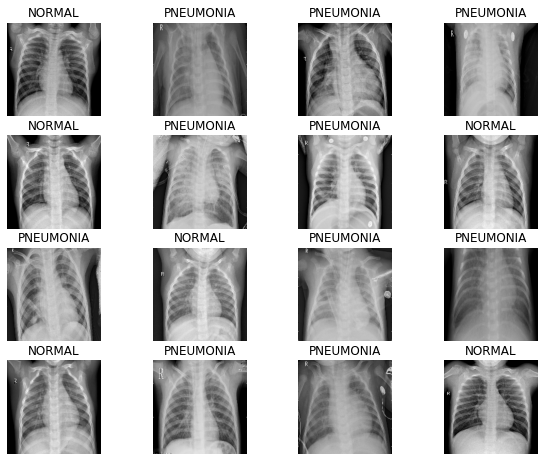

In [70]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## CNN 모델링

### Convolution block 만들기

In [79]:
# def conv_block(filters):
#     block = tf.keras.Sequential([
#         tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.SeparableConv2D(filters, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.BatchNormalization,
#         tf.keras.layers.MaxPool2D()
#     ])
    
#     return block

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense block 만들기

In [80]:
# def dense_block(units, dropout_rate):
#     block = tf.keras.Sequential([
#         tf.keras.layers.Dense(units, activation = 'relu'),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dropout(dropout_rate)
#     ])
    
#     return block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### 모델 설계하기

In [81]:
# def build_model():
#     model = tf.keras.Sequential([
#         tf.keras.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
#         tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same'),
#         tf.keras.layers.MaxPool2D(),
        
#         conv_block(32),
#         conv_block(64),
#         conv_block(128),
#         tf.keras.layers.Dropout(0.2),
#         conv_block(256),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Flatten(),
#         dense_block(512, 0.7),
#         dense_block(128, 0.5),
#         dense_block(64, 0.3),
        
#         tf.keras.layers.Dense(1, activation = 'sigmoid') # 왜 1이지?? 2가 아니고?? 양성, 음성을 분류하는게 아닌가??
#     ])
    
#     return model

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 불균형한 데이터 처리하기
- 

In [82]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [83]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'), # 그냥 'precision' 이렇게 쓰면 안됨??
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [84]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 92s 246ms/step - loss: 0.4868 - accuracy: 0.7514 - precision: 0.9383 - recall: 0.7202 - val_loss: 0.6223 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 64s 247ms/step - loss: 0.2324 - accuracy: 0.9045 - precision: 0.9708 - recall: 0.8987 - val_loss: 0.8859 - val_accuracy: 0.7317 - val_precision: 0.7317 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 63s 241ms/step - loss: 0.2260 - accuracy: 0.9112 - precision: 0.9722 - recall: 0.9074 - val_loss: 0.1048 - val_accuracy: 0.9740 - val_precision: 0.9706 - val_recall: 0.9948
Epoch 4/25
261/261 [==============================] - 63s 243ms/step - loss: 0.1855 - accuracy: 0.9213 - precision: 0.9778 - recall: 0.9151 - val_loss: 0.1448 - val_accuracy: 0.9481 - val_precision: 0.9383 - val_recall: 0.9948
Epoch 5/25
261/261 [==============================] - 64s 247ms/step - loss: 0.1623 - accura

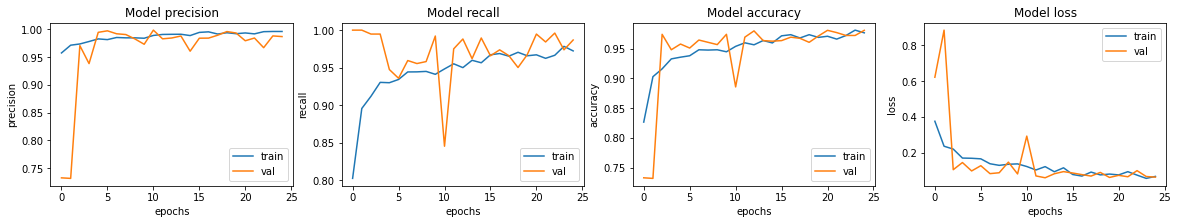

In [85]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [86]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 142ms/step - loss: 1.0439 - accuracy: 0.8061 - precision: 0.7663 - recall: 0.9923
Loss: 1.043948769569397,
Accuracy: 0.8060897588729858,
Precision: 0.7663366198539734,
Recall: 0.9923076629638672
